In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

<h1>Model</h1>

In [3]:
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = X_train / 255.0
X_val   = X_val   / 255.0
X_train = X_train[..., tf.newaxis]
X_val   = X_val[..., tf.newaxis]

In [8]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [10]:
# (28 - 3) // 3 + 1
# (9 - 3) // 3 + 1

In [11]:
layers1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
])

layers2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

In [13]:
class ConvModel(tf.keras.Model):
    def __init__(self, layers1, layers2):
        super().__init__()
        self.layers1 = layers1
        self.layers2 = layers2
        
    def call(self, x, training=False):
        x = self.layers1(x)
        x = self.layers2(x)
        return x

model = ConvModel(layers1, layers2)

In [14]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer2 = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
train_loss_metric = tf.keras.metrics.Mean()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_loss_metric = tf.keras.metrics.Mean()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [17]:
@tf.function
def train_step(X, y):
    with tf.GradientTape(persistent=True) as tape:
        logits = model(X, training=True)
        loss = loss_fn(y, logits)
    
    grads = tape.gradient(loss, model.trainable_variables)
    vars_layers_1 = model.layers1.trainable_variables
    vars_layers_2 = model.layers2.trainable_variables

    grads_layers_1 = grads[:len(vars_layers_1)]
    grads_layers_2 = grads[len(vars_layers_1):]

    optimizer1.apply_gradients(zip(grads_layers_1, vars_layers_1))
    optimizer2.apply_gradients(zip(grads_layers_2, vars_layers_2))

    train_loss_metric.update_state(loss)
    train_acc_metric.update_state(y, logits)

In [20]:
@tf.function
def val_step(X, y):
    logits = model(X, training=False)
    loss = loss_fn(y, logits)
    val_loss_metric.update_state(loss)
    val_acc_metric.update_state(y, logits)

In [19]:
train_loss_results = []
train_acc_results = []
val_loss_results = []
val_acc_results = []

In [26]:
epochs = 5
log_steps = 100

def train():
    for epoch in range(epochs):
        print(f"--- epoch {epoch + 1}\n")
        train_loss_metric.reset_state()
        train_acc_metric.reset_state()
        val_loss_metric.reset_state()
        val_acc_metric.reset_state()
    
        for step, (X, y) in enumerate(train_ds):
            train_step(X, y)
    
            if step % log_steps == 0:
                print(f"\nepoch: {epoch}, step: {step}")
                print(f"Mean Loss: {train_loss_metric.result():.4f}")
                print(f"Mean Accuracy: {train_acc_metric.result():.4f}")
    
        for x_batch, y_batch in val_ds:
            val_step(x_batch, y_batch)
    
        train_loss = train_loss_metric.result()
        val_loss = val_loss_metric.result()
        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()

        
        train_loss_results.append(train_loss)
        train_acc_results.append(train_acc)
        val_loss_results.append(val_loss)
        val_acc_results.append(val_acc)
    
        print(f"\nEpoch {epoch+1} summary:")
        print(f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {train_acc:.4f} | "
              f"Val Acc:   {train_acc:.4f}")

In [27]:
train()

--- epoch 1


epoch: 0, step: 0
Mean Loss: 0.4283
Mean Accuracy: 0.8125

epoch: 0, step: 100
Mean Loss: 0.4338
Mean Accuracy: 0.8465

epoch: 0, step: 200
Mean Loss: 0.4449
Mean Accuracy: 0.8415

epoch: 0, step: 300
Mean Loss: 0.4492
Mean Accuracy: 0.8407

epoch: 0, step: 400
Mean Loss: 0.4445
Mean Accuracy: 0.8423

epoch: 0, step: 500
Mean Loss: 0.4413
Mean Accuracy: 0.8443

epoch: 0, step: 600
Mean Loss: 0.4405
Mean Accuracy: 0.8452

epoch: 0, step: 700
Mean Loss: 0.4402
Mean Accuracy: 0.8457

epoch: 0, step: 800
Mean Loss: 0.4402
Mean Accuracy: 0.8450

epoch: 0, step: 900
Mean Loss: 0.4398
Mean Accuracy: 0.8449

Epoch 1 summary:
Train Loss: 0.4386 | Train Acc: 0.8451
Val Loss:   0.8451 | Val Acc:   0.8451
--- epoch 2


epoch: 1, step: 0
Mean Loss: 0.4797
Mean Accuracy: 0.8594

epoch: 1, step: 100
Mean Loss: 0.4161
Mean Accuracy: 0.8529

epoch: 1, step: 200
Mean Loss: 0.4194
Mean Accuracy: 0.8524

epoch: 1, step: 300
Mean Loss: 0.4224
Mean Accuracy: 0.8507

epoch: 1, step: 400
Mean Lo

2025-11-29 14:21:32.373401: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3 summary:
Train Loss: 0.4055 | Train Acc: 0.8579
Val Loss:   0.8579 | Val Acc:   0.8579
--- epoch 4


epoch: 3, step: 0
Mean Loss: 0.3090
Mean Accuracy: 0.8750

epoch: 3, step: 100
Mean Loss: 0.4022
Mean Accuracy: 0.8608

epoch: 3, step: 200
Mean Loss: 0.4004
Mean Accuracy: 0.8604

epoch: 3, step: 300
Mean Loss: 0.3977
Mean Accuracy: 0.8609

epoch: 3, step: 400
Mean Loss: 0.3962
Mean Accuracy: 0.8613

epoch: 3, step: 500
Mean Loss: 0.3959
Mean Accuracy: 0.8614

epoch: 3, step: 600
Mean Loss: 0.3935
Mean Accuracy: 0.8622

epoch: 3, step: 700
Mean Loss: 0.3926
Mean Accuracy: 0.8624

epoch: 3, step: 800
Mean Loss: 0.3923
Mean Accuracy: 0.8625

epoch: 3, step: 900
Mean Loss: 0.3912
Mean Accuracy: 0.8631

Epoch 4 summary:
Train Loss: 0.3917 | Train Acc: 0.8629
Val Loss:   0.8629 | Val Acc:   0.8629
--- epoch 5


epoch: 4, step: 0
Mean Loss: 0.3052
Mean Accuracy: 0.9062

epoch: 4, step: 100
Mean Loss: 0.3784
Mean Accuracy: 0.8719

epoch: 4, step: 200
Mean Loss: 0.3805
Mean Accuracy: 

In [28]:
def plot_results():
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss_results, label="Train Loss")
    plt.plot(val_loss_results, label="Val Loss")
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_results, label="Train Acc")
    plt.plot(val_acc_results, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()
    
    plt.show()

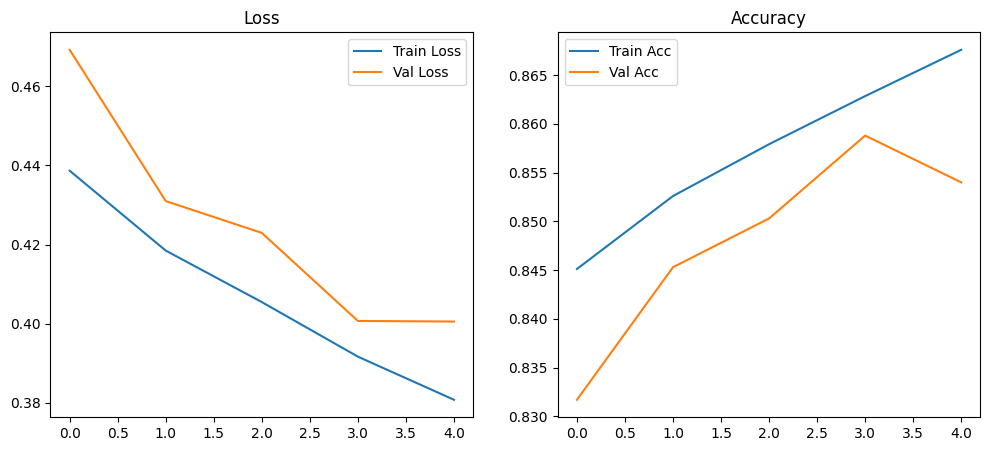

In [30]:
plot_results()

<h1>Question 1</h1>

To me, custom layers and custom models are used to do completely different things. A custom layer is used to define a computation that is not supported by the existing layers. For example, you may want a custom dense layer in which the weight matrix is the product of two low rank matrices as in LoRA. Another example is when we want a custom activation function.
On the other hand, a custom model is used to combine layers. One use case is for an architecture that contains skip layers so the model is not sequential. A custom model is also needed when the forward pass logic depends on the data and/or uses conditionals and loops, which the sequential and functional model cannot do. 

<h1>Question 2</h1>

We need to use a dynamic model if the forward pass is not fixed and depends on the input data, or more generally, uses python control flow. 

The syntax for creating a dynamic model is the same as creating a custom model

In [32]:
class CustomModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

What makes it dynamic is the control flow statements in the call function

We need to use a dynamic model if the forward pass is not fixed and depends on the input data, or more generally, uses python control flow. Some examples where we need to use a dynamic model are the following.

1. When the forward pass logic depends on the input data, we will if/else statements in the call method.
2. An RNN that handles sequences of variable lengths and needs to unroll manually.

However, making a model dynamic has some downsides

1. Static models have fixed computation graphs. This allows TensorFlow to optimize operations to run faster and use less memory. A dynamic model relies on eager execution and thus does not admit certain optimizations.
2. Due to the controls flow statements, a dynamic model is harder to deploy to formats like ONNX. This makes deployment harder.
3. 